#Applying pattern recognition to the financial market

###- Product


by Santiago Licea

In [ ]:
!pip install --quiet pmdarima
!pip install --quiet arch
!pip install --quiet reportlab

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette('pastel')
import yfinance as yf
import random
import datetime
from datetime import datetime, timedelta, date
import time
from google.colab import drive
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from arch.__future__ import reindexing #to shut down warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go

For detailed explanations of the code, as well as further testing of variants of each model, consult the Testing notebook. This will be the notebook that's going to be run on a daily basis. As mentioned in the testing notebook, we could have access to more historical data for certain companies and more time series variables if we paid a monthly subscription to use the Alpha Vantage API. However, for this Beta product, we are only going to use the yfinance API.

###Data extraction.

In [ ]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
df['Symbol'] = df.Symbol.str.replace('.', '-')
tickers = list(df.Symbol.values)

<ipython-input-3-3a839b743f33>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Symbol'] = df.Symbol.str.replace('.', '-')


In [ ]:
dicCompanies = {}
startDate = '2018-01-01'
endDate = date.today().strftime('%Y-%m-%d')
for i in tickers:
  #Yahoo finance API call:
  df = yf.download(i, start = startDate, end = endDate, progress = False)
  df.reset_index(inplace=True)
  df['Date'] = pd.to_datetime(df['Date'])
  dicCompanies[i] = df

In [ ]:
def ROI(adjClose): #Return of investment
  returns = []
  for i in range(len(adjClose)-1):
    returns.append((adjClose[i+1]-adjClose[i])/adjClose[i])
  return np.array(returns)

###ARIMA (10 min)

In [ ]:
random.seed(1)

In [ ]:
window = 90 #we discount the testing observations from the other notebook
endDate = datetime.today()
startDate = endDate - timedelta(days=window)

arimaPreds = []
for ticker in tickers:
  returns = ROI(dicCompanies[ticker].query('Date >= @startDate & Date <= @endDate')['Adj Close'].values)

  model = pm.auto_arima(returns, d=0, error_action='ignore', suppress_warnings=True)
  model.fit(returns)
  arimaPreds.append(model.predict(n_periods=1)[0])

In [ ]:
arimaPreds = [0 if i==0.0 else i for i in arimaPreds]

###EMA (<1 min)

In [ ]:
window = 100
endDate = datetime.today()
startDate = endDate - timedelta(days=window)

emaPreds = []
for ticker in tickers:
  returns = ROI(dicCompanies[ticker].query('Date >= @startDate & Date <= @endDate')['Adj Close'].values)
  shortEma = pd.Series(returns).ewm(span=12, adjust=False).mean()
  emaPreds.append(shortEma.values[-1])

###VARMA (45 min)

It takes 45 minutos to predict for all 500 companies. Let's just predict for 50 for the moment.

In [ ]:
window = 100
endDate = datetime.today()
startDate = endDate - timedelta(days=window)

bestParamsArr = []
varmaPreds = []
for ticker in tickers[:50]: #50 sample
  df = dicCompanies[ticker].query('Date >= @startDate & Date <= @endDate')[['Adj Close', 'Volume']]
  returns = ROI(df['Adj Close'].values)
  volume = df['Volume'].diff().values[1:]

  df = pd.DataFrame({'returns': returns, 'volumeDiff': volume})
  scaler = MinMaxScaler()
  df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

  bestAIC = np.inf
  bestParams = None
  for p in range(3):
    for q in range(3):
      try:
        model = VARMAX(df[['returns', 'volumeDiff']], order=(p, q)).fit(disp=False)
        aic = model.aic
        if aic < bestAIC:
          bestAIC = aic
          bestParams = (p, q)
      except:
        continue
  bestParamsArr.append(bestParams)
  if bestParams != None:
    model = VARMAX(df[['returns', 'volumeDiff']], order=bestParams).fit(disp=False)
    varmaPreds.append(scaler.inverse_transform(model.forecast(steps=1))[0, 0])
  else:
    varmaPreds.append(0)

In [ ]:
for i in range(len(tickers)-50):
  varmaPreds.append(0)

###GARCH (4 min)

The parameters we obtain for each company in the following block can be used for at least 100 days, so there's no need to run this daily, although it doesn't take too much time.

In [ ]:
random.seed(1)

endDate = datetime.today()
window = 1500
startDate = endDate - timedelta(days=window)

bestParamsArr = []
for ticker in tickers:
  returns = ROI(dicCompanies[ticker].query(f'Date >= @startDate & Date <= @endDate')['Adj Close'].values)*100

  bestAIC = np.inf
  bestParams = None
  for p in range(4):
    for q in range(4):
      try:
        model = arch_model(returns, p=p, q=q).fit(disp='off')
        aic = model.aic
        if aic < bestAIC:
          bestAIC = aic
          bestParams = (p, q)
      except:
        continue
  bestParamsArr.append(bestParams)

In [ ]:
garchPreds = []
for i in range(len(tickers)):
  returns = ROI(dicCompanies[tickers[i]].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values)*100
  model = arch_model(returns, p=bestParamsArr[i][0], q=bestParamsArr[i][1]).fit(disp='off')
  garchPreds.append(model.forecast(horizon=1).variance.values[-1, :][0]**0.5)

###LSTM (3-4 hr)

In [ ]:
random.seed(1)
endDate = datetime.today()
window = 1550
startDate = endDate - timedelta(days=window)

lstmPreds = []
for ticker in tickers[:10]: #first 10
  returns = ROI(dicCompanies[ticker].query(f'Date >= @startDate and Date <= @endDate')['Adj Close'].values)
  scaler = MinMaxScaler()
  returns = scaler.fit_transform(returns.reshape(-1, 1))

  # LSTM input
  X = []
  y = []
  Xpred = []
  lookback = 10  # we chose this lookback window due to the volatility of stock returns
  for i in range(lookback, len(returns)):
    X.append(returns[i - lookback:i, 0])
    y.append(returns[i, 0])
  Xpred.append(returns[-lookback:])
  X, y, Xpred = np.array(X), np.array(y), np.array(Xpred)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # to 3D array
  Xpred = np.reshape(Xpred, (Xpred.shape[0], Xpred.shape[1], 1))

  # LSTM model
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compiling
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train
  model.fit(X, y, batch_size=50, epochs=50, verbose=0)

  # Predict
  prediction = model.predict(Xpred)
  lstmPreds.append(scaler.inverse_transform(prediction))

1/1 [==============================] - 1s 680ms/step


1/1 [==============================] - 1s 524ms/step


1/1 [==============================] - 1s 521ms/step


In [ ]:
lstmPreds = [i[0][0] for i in lstmPreds]

In [ ]:
for i in range(len(tickers)-10):
  lstmPreds.append(0)

###Export

In [ ]:
dfProduct = pd.DataFrame({'Tickers': tickers, 'ARIMA': arimaPreds, 'EMA': emaPreds,
                               'VARMA': varmaPreds, 'GARCH': garchPreds, 'LSTM': lstmPreds})

dfProduct.to_csv('dfProduct.csv', index=False)
files.download('dfProduct.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Kmeans:

In [ ]:
dimensions = ['trailingPE', 'returnOnEquity', 'dividendYield', 'beta', 'marketCap', 'debtToEquity']
dicInfo = {}
for ticker in tickers:
  dicInfo[ticker] = []
  dicTicker = yf.Ticker(ticker).info
  for dim in dimensions:
    try:
      dicInfo[ticker].append(dicTicker[dim])
    except:
      continue

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

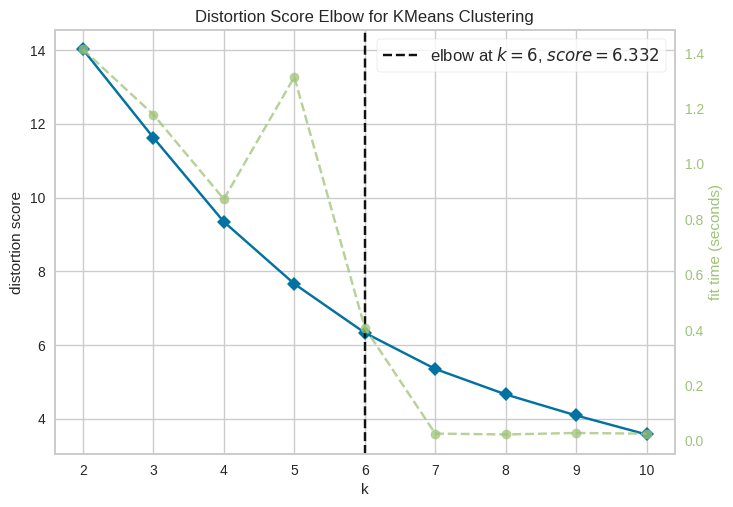

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
dicInfo2 = {}
for i in dicInfo.keys():
  if len(dicInfo[i])==6:
    dicInfo2[i] = dicInfo[i]
X = []
for i in dicInfo2.keys():
  X.append(dicInfo2[i])

X = np.array(X)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 11))
visualizer.fit(X)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
labels = pd.Categorical(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
zero = [i==0 for i in labels]
one = [i==1 for i in labels]
two = [i==2 for i in labels]
three = [i==3 for i in labels]
four = [i==4 for i in labels]
five = [i==5 for i in labels]

groups = [zero, one, two, three, four, five]
colors = ['#003f5c', '#bc5090', '#ffa600', '#90EE90', '#ADD8E6', '#000000']
names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
dimensions = ['trailingPE', 'returnOnEquity', 'dividendYield', 'beta', 'marketCap', 'debtToEquity']

datos = pd.DataFrame(data=X, columns=dimensions)

for indicador in dimensions:
  fig = go.Figure()
  for i, c, t in zip(groups, colors, names):
    df_cluster = datos[i]
    boxplot = go.Box(y=df_cluster[indicador], name=t, marker_color=c)
    fig.add_trace(boxplot)
  fig.update_layout(title=indicador, title_x=0.5, title_y=0.95, yaxis_title=indicador)
  fig.show()

In [ ]:
print(np.sum(zero))
print(np.sum(one))
print(np.sum(two))
print(np.sum(three))
print(np.sum(four))
print(np.sum(five))

101
96
100
2
29
2


In [ ]:
companies = list(dicInfo2.keys())
for k in [zero, one, two, three, four, five]:
  print([companies[i] for i, j in enumerate(k) if j])

['ABBV', 'ADM', 'AFL', 'APD', 'ARE', 'LNT', 'AMCR', 'AEE', 'AEP', 'AMT', 'AMGN', 'AIZ', 'ATO', 'AVB', 'BMY', 'BG', 'CHRW', 'CPT', 'CPB', 'CNP', 'CVX', 'CINF', 'CSCO', 'CLX', 'CME', 'CMS', 'KO', 'CL', 'CMCSA', 'CAG', 'ED', 'GLW', 'CCI', 'CMI', 'CVS', 'DLR', 'D', 'DTE', 'DUK', 'EIX', 'ETR', 'EQR', 'ESS', 'ES', 'EXC', 'EXR', 'XOM', 'FE', 'GRMN', 'GEN', 'GD', 'GIS', 'GILD', 'HIG', 'HAS', 'HRL', 'HII', 'IBM', 'IPG', 'INVH', 'IRM', 'JNJ', 'JNPR', 'K', 'KDP', 'KMB', 'KHC', 'KR', 'LHX', 'LMT', 'MDT', 'MRK', 'MET', 'MAA', 'NEE', 'NI', 'OMC', 'PKG', 'PAYX', 'PEP', 'PFE', 'PNW', 'PPL', 'PG', 'PLD', 'PEG', 'PSA', 'RTX', 'O', 'SRE', 'SJM', 'SO', 'TGT', 'TXN', 'TRV', 'TSN', 'UDR', 'UPS', 'WEC', 'WELL', 'XEL']
['AOS', 'ACN', 'ALB', 'AXP', 'AIG', 'AMP', 'AME', 'APH', 'ADI', 'APA', 'AMAT', 'TECH', 'BLK', 'BWA', 'AVGO', 'CARR', 'CE', 'CTAS', 'COP', 'CSX', 'DHI', 'DRI', 'DFS', 'DOV', 'DD', 'EMN', 'ETN', 'EBAY', 'EMR', 'EOG', 'EQT', 'EFX', 'FAST', 'FDX', 'FCX', 'GM', 'GS', 'HAL', 'HES', 'HPE', 'HON', 'HST